# SDDP:  advanced tutorial

Consider two dams in the same valley. These two dams are connected together, as we suppose that the water turbined by the first dam is an input of the second dam. The goal of this notebook is to show how to use the Stochastic Dual Dynamic Programming (SDDP) algorithm to find how to manage optimally these two dams. 

## Mathematical formulation:

We use a hydropower management testcase. 

We consider a valley with $N_{dams}$, all in the same river. 

### Dynamic

Assume that we have a water inflow $W_t^i$ which arrives in the $i$-th dam between $t$ and $t+1$. This dam turbines a quantity $U_t^i$ of water, and spill a quantity $S_t^i$ (to achieve relatively complete recourse). 

Thus, dynamic of first dam becomes: 

$$ X_{t+1}^1 = X_{t}^1 + W^t - U_t^1 - S_t^1 $$

The turbined flow arrives in the second dam, which turbines a quantity $U_t^2$ and spills a quantity $S_t^2$, and so on for $i \in [[2, N_{dams}|]$. So for all $i \geq 1$, we have the dynamic:

$$ X_{t+1}^i = X_{t}^i + U_t^{i-1} + S_t^{i-1} - U_t^i - S_t^i + W_t^i$$

Thus, we could define the state:
$$ X_t = (X_t^i)_{i=1}^{N_{dams}}$$

and the control:
$$U_t = (U_t^i, S_t^i)_{i=1}^{N_{dams}} $$

### Costs

The two turbines produce a quantity of electricity proportionnal to the flow turbined, and this electricity is sold into the market at a price $c_t$. So we gain at each timestep:

$$ C_t(X_t, U_t) = c_t  \sum_{i=1}^{N_{dams}} U_t^i $$

Here, we suppose that costs are negative, as we sell electricity onto the network. 

We want to maximize our expected gains, so we minimize the following quantity:

$$ J = \mathbb{E} \left[ \sum_{i=1}^{T_f} C_t(X_t, U_t) \right]$$ 


--- 

## Problem formulation: 

First, we need to import some modules: 

In [3]:
using StochDynamicProgramming, JuMP, CPLEX #,Clp, Gurobi

In [6]:
using PyPlot

In [4]:
# and we set a random seed for replicatibility:
srand(2713);

### Implementation of stochastic problem: 

We set the number of dams in our valley: 

In [5]:
const N_DAMS = 5

5

In [7]:
const N_STAGES = 12
const N_ALEAS = 10


10

### Definition of bounds upon states and controls

In [10]:
# Constants:
const VOLUME_MAX = 80
const VOLUME_MIN = 0

const CONTROL_MAX = 40
const CONTROL_MIN = 0

# Define initial status of stocks:
const X0 = [40 for i in 1:N_DAMS];

### Definition of noise's laws: 

In [21]:

noiselaws = Vector{NoiseLaw}(N_STAGES-1)
# uniform probabilities:
proba = 1/N_ALEAS*ones(N_ALEAS)

for t=1:N_STAGES-1
    support = rand(0:9, N_DAMS, N_ALEAS)
    noiselaws[t] = NoiseLaw(support, proba)
end




### Definition of dynamic: 

In [12]:
# Dynamic of stocks:
const A = eye(N_DAMS)
# The problem has the following structure:
# dam1 -> dam2 -> dam3 -> dam4 -> dam5
# We need to define the corresponding dynamic:
const B =  [-1  0.  0.  0.  0.  -1  0.  0.  0.  0.;
            1.  -1  0.  0.  0.  1.  -1  0.  0.  0.;
            0.  1.  -1  0.  0.  0.  1.  -1  0.  0.;
            0.  0.  1.  -1  0.  0.  0.  1.  -1  0.;
            0.  0.  0.  1.  -1  0.  0.  0.  1.  -1]
# Define dynamic of the dam:
function dynamic(t, x, u, w)
    return A*x + B*u + w
end

dynamic (generic function with 1 method)

### Definition of costs: 

In [8]:
# Cost are negative as we sell the electricity produced by
# dams (and we want to minimize our problem)
const COST = -66*2.7*(1 + .5*(rand(N_STAGES) - .5))

# Define cost corresponding to each timestep:
function cost_t(t, x, u, w)
    return COST[t] * sum(u[1:N_DAMS])
end

cost_t (generic function with 1 method)

### Definition of final cost: 

In [35]:
function final_cost_dams(model, m)
    alpha = JuMP.getvariable(m, :alpha)
    w = JuMP.getvariable(m, :w)
    x = JuMP.getvariable(m, :x)
    u = JuMP.getvariable(m, :u)
    xf = JuMP.getvariable(m, :xf)
    @JuMP.variable(m, z1[1:N_DAMS] >= 0)
    @JuMP.constraint(m, alpha == 0.)
    @JuMP.constraint(m, z1 .>= 40. - xf)
    @JuMP.objective(m, Min, model.costFunctions(model.stageNumber-1, x, u, w) +
                            500*sum(z1'*z1))
end


final_cost_dams (generic function with 1 method)

### Definition of SPModel:

In [18]:
x_bounds = [(VOLUME_MIN, VOLUME_MAX) for i in 1:N_DAMS]
u_bounds = vcat([(CONTROL_MIN, CONTROL_MAX) for i in 1:N_DAMS], [(0., 200) for i in 1:N_DAMS]);

In [36]:
model = LinearSPModel(N_STAGES, # number of states in our problem
                    u_bounds, # bounds upon control
                    X0, # initial position 
                    cost_t, # instantaneous cost
                    dynamic, # dynamic 
                    noiselaws, # noises modelling 
                    Vfinal=final_cost_dams # Final cost
                    );

In [37]:
# Add bounds for stocks:
set_state_bounds(model, x_bounds);

## Parametrization of SDDP: 

In [38]:
solver = CPLEX.CplexSolver(CPX_PARAM_SIMDISPLAY=0, CPX_PARAM_BARDISPLAY=0);


In [54]:
params = SDDPparameters(solver,
                        passnumber=10,
                        max_iterations=50);


## Solving 

In [59]:
srand(111)
V, pbs, stats = @time solve_SDDP(model, params, 10);

Initial value function loaded into memory.
Initialize cuts
Pass number 10	Lower-bound: -149643.7015	Time: 0.34s
Pass number 20	Lower-bound: -139616.4627	Time: 0.32s
Pass number 30	Lower-bound: -139363.1817	Time: 0.76s
Pass number 40	Lower-bound: -139335.8289	Time: 0.53s
Pass number 50	Lower-bound: -139314.6985	Time: 0.59s
 22.010530 seconds (13.31 M allocations: 1.672 GB, 2.41% gc time)


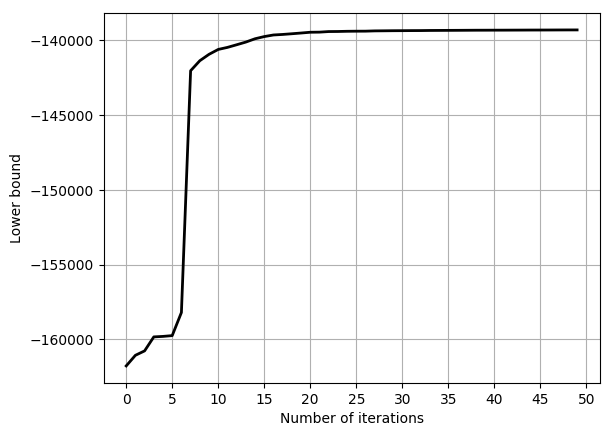

In [44]:
# We plot evolution of lower-bound: 
plot(stats.lower_bounds, lw=2, c="k")
grid()
xticks([0:5:50], [0:5:50])
xlabel("Number of iterations")
ylabel("Lower bound");

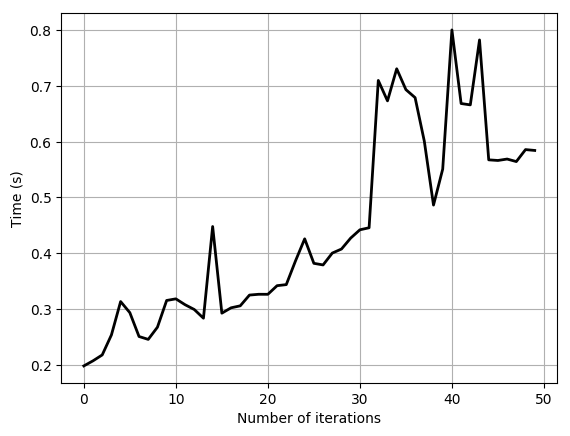

In [47]:
# and evolution of execution time: 
plot(stats.exectime, lw=2, c="k")
grid()

xlabel("Number of iterations")
ylabel("Time (s)");

## Quadratic regularization 

In [56]:
params2 = SDDPparameters(solver,
                        passnumber=10,
                        rho0=.1, alpha=.99, 
                        max_iterations=50);

In [60]:
srand(111)
stats2 = @time solve_SDDP(model, params2, 10)[3];

Acceleration: ON
Initial value function loaded into memory.
Initialize cuts
Pass number 10	Lower-bound: -141327.3656	Time: 0.58s
Pass number 20	Lower-bound: -139387.8833	Time: 0.65s
Pass number 30	Lower-bound: -139325.9669	Time: 0.81s
Pass number 40	Lower-bound: -139305.0324	Time: 1.03s
Pass number 50	Lower-bound: -139294.221	Time: 1.28s
 40.259391 seconds (20.27 M allocations: 2.116 GB, 1.51% gc time)


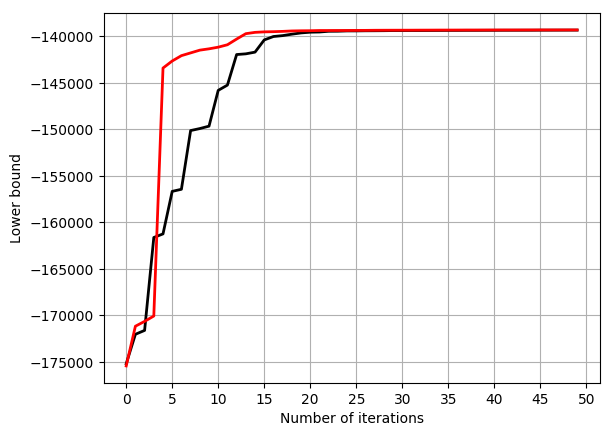

In [61]:
plot(stats.lower_bounds, lw=2, c="k")
plot(stats2.lower_bounds, lw=2, c="r")
grid()
xticks([0:5:50], [0:5:50])
xlabel("Number of iterations")
ylabel("Lower bound");

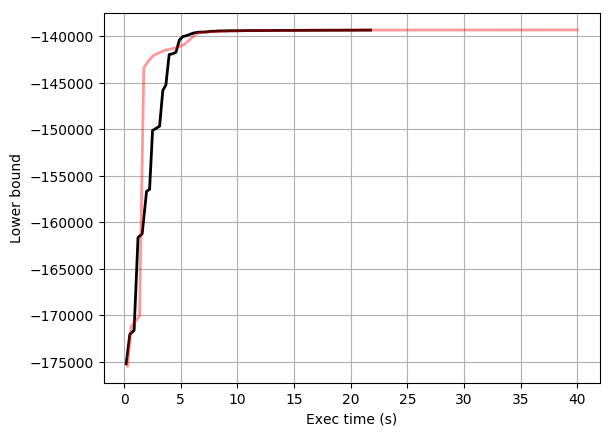

In [65]:
plot(cumsum(stats.exectime), stats.lower_bounds, lw=2, c="k")
plot(cumsum(stats2.exectime), stats2.lower_bounds, lw=2, c="r", alpha=.4)
grid()
xlabel("Exec time (s)")
ylabel("Lower bound");

## Cuts pruning

In [68]:
params3 = SDDPparameters(solver,
                        passnumber=10,
                        rho0=.1, alpha=.99, 
                        max_iterations=50,
                        prune_cuts=25, pruning_algo="exact");

In [69]:
srand(111)
stats3 = @time solve_SDDP(model, params3, 10)[3];

Acceleration: ON
Initial value function loaded into memory.
Initialize cuts
Pass number 10	Lower-bound: -141108.4891	Time: 0.55s
Pass number 20	Lower-bound: -139398.2691	Time: 0.63s
Prune cuts ... Deflation: 0.534 
Pass number 30	Lower-bound: -139336.6124	Time: 0.61s
Pass number 40	Lower-bound: -139313.9428	Time: 0.77s
Pass number 50	Lower-bound: -139302.0884	Time: 0.96s
Prune cuts ...

 Deflation: 0.632 
 46.214004 seconds (99.42 M allocations: 7.000 GB, 3.84% gc time)


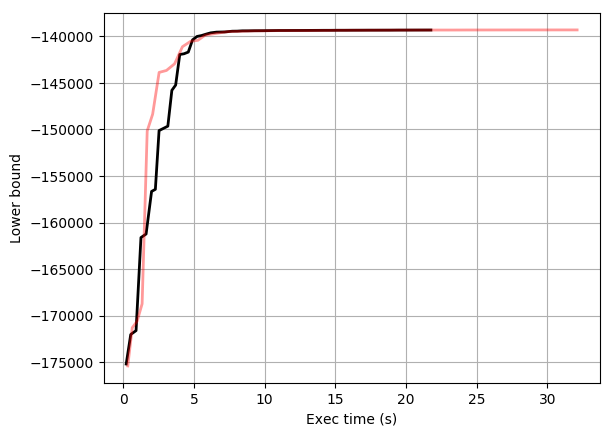

In [70]:
plot(cumsum(stats.exectime), stats.lower_bounds, lw=2, c="k")
plot(cumsum(stats3.exectime), stats3.lower_bounds, lw=2, c="r", alpha=.4)
grid()
xlabel("Exec time (s)")
ylabel("Lower bound");

In [76]:
params4 = SDDPparameters(solver,
                        passnumber=10,
                        rho0=.1, alpha=.99, 
                        max_iterations=50,
                        prune_cuts=10, pruning_algo="territory");

In [79]:
srand(111)
stats4 = @time solve_SDDP(model, params4, 10)[3];

Acceleration: ON
Initial value function loaded into memory.
Initialize cuts
Pass number 10	Lower-bound: -139871.6738	Time: 0.57s
Prune cuts ... Deflation: 0.312 
Pass number 20	Lower-bound: -139373.7358	Time: 0.57s
Prune cuts ... Deflation: 0.467 
Pass number 30	Lower-bound: -139332.1943	Time: 0.61s
Prune cuts ... Deflation: 0.601 
Pass number 40	Lower-bound: -139317.2904	Time: 0.66s
Prune cuts ... Deflation: 0.648 
Pass number 50	Lower-bound: -139306.5816	Time: 0.72s
Prune cuts ... Deflation: 0.683 
 32.002206 seconds (45.37 M allocations: 2.466 GB, 2.14% gc time)


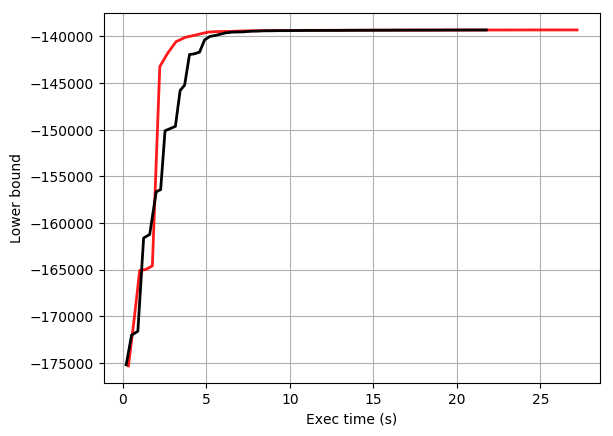

In [81]:
plot(cumsum(stats4.exectime), stats4.lower_bounds, lw=2, c="r", alpha=.9)
plot(cumsum(stats.exectime), stats.lower_bounds, lw=2, c="k")
grid()
xlabel("Exec time (s)")
ylabel("Lower bound");